<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2

## Problem Statement

Suppose that I was a Data Scientist hired by a private real estate firm. The firm would like to know how much they should set their price estimate according to the house's features when purchasing houses from property owners. 

This project aims to answer that question based on a given dataset and regression models.

### Contents:
- [Background](#Background)
- [Preprocessing](#Preprocessing)
- [Feature Selection & Engineering](#Feature-Selection-&-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Modelling](#Data-Modelling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

### Datasets Used

* [`test.csv`](../datasets/test.csv): Kaggle dataset
* [`train.csv`](../datasets/train.csv): Training dataset

## Preprocessing

### Library Imports

In [1]:
# basic libraries
import numpy as np
import pandas as pd

# scikit-learn libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import(
    LinearRegression,
    Ridge,
    RidgeCV,
    Lasso,
    LassoCV,
    LogisticRegression,
    LogisticRegressionCV,
    ElasticNetCV
)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Import

In [2]:
# read in relevant csvs
test = pd.read_csv('../datasets/new_test.csv')
train = pd.read_csv('../datasets/train.csv')

### Functions Used

In [3]:
# Function to fill np.nans for list
def fill_na_list(list_, df):
    for name in list_:
        df[name] = df[name].fillna(0)

In [4]:
# Function to rename column names and replace whitespace with underscore
def lower_names(df):
    df.columns = df.columns.str.replace(' ','_')
    df.columns = df.columns.str.lower()
    return df

In [5]:
# Function to plot histogram for two variables
def plot_hist(x_, y_, df):
    plt.subplots(figsize=(10,5))
    sns.histplot(
        x=x_,
        y=y_,
        data=df
    );

In [6]:
# Function to group two columns and drop those columns, then dummify new column
def group_and_drop(new_var, col1, col2, df):
    df[new_var] = df[col1]+'_'+df[col2] # grouping
    df = df.drop(columns=[col1,col2]) # dropping original columns
    return df

In [7]:
# Function to numerically encode a common ordinal scale found in this data
# Poor = 1, Fair = 2, Average = 3, Good = 4, Excellent = 5
def encode_scale(col, df):
    df[col] = df[col].map(
        {
            0: 0,
            'Po': 1,
            'Fa': 2,
            'TA': 3,
            'Gd': 4,
            'Ex': 5
        }
    )
    return df

In [8]:
# Replace with new column, value being mean and drop original columns
def mean_drop(col1, col2, new_var, df):
    encode_scale(col1, df) # encode col1
    encode_scale(col2, df) # encode col2
    df[new_var] = (df[col1] + df[col2]) / 2 # get mean in new var col
    df = df.drop(columns=[col1, col2]) # drop original columns
    return df

In [9]:
# Binarize columns with only two values
def binarize_(col, new_col, val1, val0, df):
    df[new_col] = df[col].map({val1: 1, val0: 0})
    df = df.drop(columns=[col]) # drop original column
    return df

In [10]:
# Plot histograms for a list of variables
def plot_list_hists(list_, df):
    for var in list_:
        plt.subplots(figsize=(5,5))
        sns.histplot(x=var, data=df, kde=True)

### Data Cleaning

According to the source (http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), there are 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables.

In [11]:
train.shape

(2051, 81)

In [12]:
# ENSURE NUMBER OF ROWS IS SAME AT THE END
test.shape

(879, 80)

Note that there is one extra column that is not considered a variable in the documentation.

In [13]:
train.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


The column is the Id column which will be important in the submission to Kaggle later. We will save it for now and rejoin it later.

In [14]:
train_id = train['Id']
test_id = test['Id']

Now, we check if the data is complete.

In [15]:
# check for null values
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data[missing_data != 0]

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Qual        114
Garage Yr Blt      114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Cars          1
dtype: int64

Steps to be taken to deal with null values:

1. There are only 2051 - 2042 = 9 houses with pools, which makes up for 0.43% of the entire data. To make it a fair comparison, houses with Pool QC that has a non-null value will be removed. Same goes for Misc Feature (3.16%) and Alley (6.82%). The reason these houses are removed first before removing the column completely is because these features could contribute significantly to the Sale Price.


2. Because of step 1, Pool Area column which is linked to Pool QC as well as Misc Value column which is linked to Misc Feature will be both dropped.


3. We can safely assume for columns regarding garage and basement that those missing data implies a lack of garage or basement respectively because the number of missing values for each case are very similar (eg. Bsmt Cond and Bsmt Qual both have 55 missing values). In that case, we can imput a value of 0 for these missing data. But before that we should investigate why some of the numbers do not match up.


4. Masonry veneer is mainly an aesthetic feature, and thus should not have a large impact on Sale Price. The columns Mas Vnr Type and Mas Vnr Area will be dropped.


5. Remaining columns are Fence, Fireplace Qu, Lot Frontage. By observing the data, we can assume that a missing value for these features implies a lack of said feature. A value of 0 will be imputted for these missing data.

In [16]:
# Step 1 - Removing houses with pool and then dropping the column
train = train.drop(
    train.dropna(
        subset=['Pool QC']
    ).index
).drop(
    columns='Pool QC'
)

test = test.drop(columns='Pool QC')

# Repeating for Misc Feature and Alley
train = train.drop(
    train.dropna(
        subset=['Misc Feature']
    ).index
).drop(
    columns='Misc Feature'
)
train = train.drop(
    train.dropna(
        subset=['Alley']
    ).index
).drop(
    columns='Alley'
)

test = test.drop(columns='Misc Feature')
test = test.drop(columns='Alley')

In [17]:
# Step 2 - Drop Pool Area and Misc Value columns
train = train.drop(columns=['Pool Area', 'Misc Val'])

test = test.drop(columns=['Pool Area', 'Misc Val'])

In [18]:
# Step 3 - Imput value of 0 for missing data in Basement and Garage related columns
# Look at why null values in Garage Type do not add up
train.loc[
    train['Garage Type'].isna() != train['Garage Finish'].isna(),
          ['Garage Type', 'Garage Finish']
]

,Garage Type,Garage Finish
1712,Detchd,NaN


We will remove this house since there is most likely a garage, but we don't know what kind of finish it is.

In [19]:
# Remove this row 
train = train.drop(1712)

# Imput value of 0 for missing data in Garage
fill_na_list([
    'Garage Finish',
    'Garage Qual',
    'Garage Yr Blt',
    'Garage Cond',
    'Garage Type',
    'Garage Area',
    'Garage Cars'
], train)

fill_na_list([
    'Garage Finish',
    'Garage Qual',
    'Garage Yr Blt',
    'Garage Cond',
    'Garage Type',
    'Garage Area',
    'Garage Cars'
], test)

In [20]:
# Look at why null values in Bsmt Exposure and BsmtFin Type 2 do not add up
train.loc[
    train['Bsmt Exposure'].isna() != train['Bsmt Cond'].isna(),
          [
              'Bsmt Exposure',
              'Bsmt Cond',
              'BsmtFin Type 2'
          ]
]

,Bsmt Exposure,Bsmt Cond,BsmtFin Type 2
1456,NaN,TA,Unf
1547,NaN,TA,Unf
1997,NaN,TA,Unf


In [21]:
# look at why null values in bsmt cond and bsmtfin type 2 do not add up
train.loc[
    train['BsmtFin Type 2'].isna() != train['Bsmt Cond'].isna(),
          [
              'Bsmt Exposure',
              'Bsmt Cond',
              'BsmtFin Type 2'
          ]
]

,Bsmt Exposure,Bsmt Cond,BsmtFin Type 2
1147,No,TA,NaN


Similarly to the garage scenario, these houses will be dropped.

In [22]:
# Remove those rows
train = train.drop([1456, 1547, 1997, 1147])

# Imput value of 0 for missing data in Basement
fill_na_list([
    'Bsmt Exposure',
    'BsmtFin Type 2',
    'BsmtFin Type 1',
    'Bsmt Cond',
    'Bsmt Qual',
    'Bsmt Half Bath',
    'Bsmt Full Bath',
    'Bsmt Unf SF',
    'BsmtFin SF 2',
    'BsmtFin SF 1',
    'Total Bsmt SF'
], train)

fill_na_list([
    'Bsmt Exposure',
    'BsmtFin Type 2',
    'BsmtFin Type 1',
    'Bsmt Cond',
    'Bsmt Qual',
    'Bsmt Half Bath',
    'Bsmt Full Bath',
    'Bsmt Unf SF',
    'BsmtFin SF 2',
    'BsmtFin SF 1',
    'Total Bsmt SF'
], test)

In [23]:
# Step 4 - Drop masonry veneer columns
train = train.drop(columns=['Mas Vnr Type', 'Mas Vnr Area'])

test = test.drop(columns=['Mas Vnr Type', 'Mas Vnr Area'])

In [24]:
# Step 5 - Input 0 value for remaining null values
fill_na_list([
    'Fence',
    'Fireplace Qu',
    'Lot Frontage'
], train)

fill_na_list([
    'Fence',
    'Fireplace Qu',
    'Lot Frontage'
], test)

In [25]:
# final check for null values
train.isnull().sum().sort_values(ascending=False).head(1)

Id    0
dtype: int64

In [26]:
test = test.fillna(0)

In [27]:
test.isnull().sum().sort_values(ascending=False).head(1)

Id    0
dtype: int64

In [28]:
train = train.drop(columns=['Id', 'PID'])

test = test.drop(columns=['Id', 'PID'])

Now that we no longer have any missing data, we can remove the Id and PID columns.

## Feature Selection & Engineering

### Selection via Correlation

The reasons for generating a heatmap is twofold:

   1. We now look at the linear correlation between features in order to remove those that will not be significantly useful. 
    
   2. Also, we want to see if features are highly correlated together, and if they are we might want to remove them to reduce collinearity.
   
The reason we choose 0.5 as our threshold for selection is because it is considered a high correlation if it is greater than 0.5.

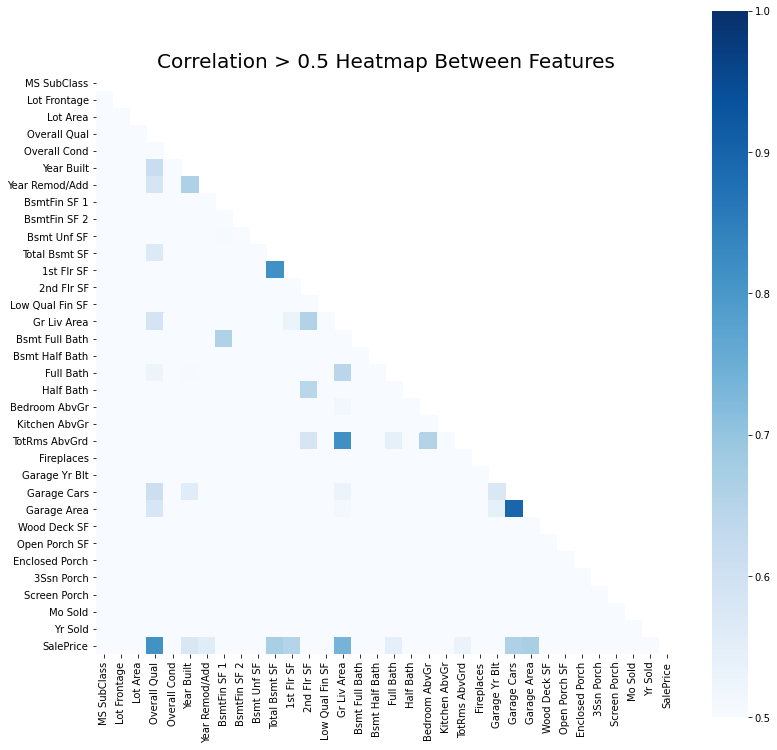

In [29]:
collinear_values = train.corr().apply(lambda x: abs(x))
collinear_values = collinear_values[collinear_values > 0.5].fillna(0)

plt.figure(figsize=(13, 13))

plt.title('Correlation > 0.5 Heatmap Between Features', fontsize=20)

mask_ = np.zeros_like(train.corr())

mask_[np.triu_indices_from(mask_)] = True

sns.heatmap(
    collinear_values,
    cmap='Blues',
    mask=mask_,
    square=True,
    vmin=0.5,
    vmax=1
);

We can see that there are several pairs of features with correlation greater than 0.5. Those that particularly stand out as features with collinearity are as follows:

   1. Year Remod/Add and Year Built 
   
       - If there was no remodelling done, the value of the two features are the same
       
       - We will add two new features: House Age (2021 - Year Built) and Remodelled (binary feature)
       
       - We will remove these two features
   
   
   2. Bsmt Full Bath and BsmtFin SF 1
   
       - We will remove Bsmt Full Bath
   
   
   3. Gr Liv Area and TotRms AbvGrd
       
       - The number of rooms is generally related to the living area
       
       - We will remove TotRms AbvGrd
       
       
   4. Bedroom AbvGr and TotRms AbvGrd
   
       - Same reasoning as 3.
       
       - We will remove Bedroom AbvGr
       
       
   5. Garage Area and Garage Cars
   
       - The number of cars a garage can fit is equivalent to garage area
       
       - We will remove Garage Cars
       
       
   6. Gr Liv Area and 1st Flr SF and 2nd Flr SF
   
       - Gr Liv Area is the sum of 1st Flr SF and 2nd Flr SF
       
       - 1st Flr SF and 2nd Flr SF will be removed
       
       
   7. BsmtFin SF 1 and BsmtFin SF 2 and Total Bsmt SF
   
       - Total Bsmt SF is the sum of BsmtFin SF 1 and BsmtFin SF 2
       
       - BsmtFin SF 1 and BsmtFin SF 2 will be removed

In [30]:
# step 1: adding new features House Age and Remodelled
train['House Age'] = 2021 - train['Year Built']

test['House Age'] = 2021 - test['Year Built']

def x_fn(row):
    row['Remodelled'] = 1 if row['Year Remod/Add'] == row['Year Built'] else 0
    return row
        
train = train.apply(x_fn, axis=1)

test = test.apply(x_fn, axis=1)

In [31]:
# removing Year Remod/Add and Year Built columns
# as well as steps 2 - 5
train = train.drop(columns=[
    'Year Remod/Add',
    'Year Built',
    'Bsmt Full Bath',
    'TotRms AbvGrd',
    'Bedroom AbvGr',
    'Garage Cars',
    '1st Flr SF',
    '2nd Flr SF',
    'BsmtFin SF 1',
    'BsmtFin SF 2'
])

test = test.drop(columns=[
    'Year Remod/Add',
    'Year Built',
    'Bsmt Full Bath',
    'TotRms AbvGrd',
    'Bedroom AbvGr',
    'Garage Cars',
    '1st Flr SF',
    '2nd Flr SF',
    'BsmtFin SF 1',
    'BsmtFin SF 2'
])

Finally, we pull out features with correlation less than 0.3 and drop them.

In [32]:
# features with correlation value less than 0.3 w.r.t. Sale Price
corr_values = train.corr()['SalePrice'].apply(lambda x: abs(x)).sort_values(ascending=False)
corr_values[(corr_values < 0.3)]

Half Bath          0.278126
Garage Yr Blt      0.256012
Bsmt Unf SF        0.204248
Lot Frontage       0.201067
Screen Porch       0.130208
Kitchen AbvGr      0.121174
Enclosed Porch     0.118478
Overall Cond       0.118157
MS SubClass        0.091113
Bsmt Half Bath     0.057095
3Ssn Porch         0.045772
Mo Sold            0.036059
Low Qual Fin SF    0.033013
Remodelled         0.019447
Yr Sold            0.018143
Name: SalePrice, dtype: float64

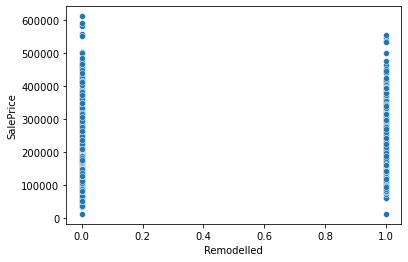

In [33]:
sns.scatterplot(x=train['Remodelled'], y=train['SalePrice']);

Interestingly, it seems that whether a house had been remodelled has no effect on the price of a house.

In [34]:
# dropping features with correlation value less than 0.2
train = train.drop(columns=[
    'Screen Porch',
    'Kitchen AbvGr',
    'Enclosed Porch',
    'Overall Cond',
    'MS SubClass',
    'Bsmt Half Bath',
    '3Ssn Porch',
    'Mo Sold',
    'Low Qual Fin SF',
    'Remodelled',
    'Yr Sold',
    'Half Bath',
    'Garage Yr Blt',
    'Bsmt Unf SF',
    'Lot Frontage'
])

test = test.drop(columns=[
    'Screen Porch',
    'Kitchen AbvGr',
    'Enclosed Porch',
    'Overall Cond',
    'MS SubClass',
    'Bsmt Half Bath',
    '3Ssn Porch',
    'Mo Sold',
    'Low Qual Fin SF',
    'Remodelled',
    'Yr Sold',
    'Half Bath',
    'Garage Yr Blt',
    'Bsmt Unf SF',
    'Lot Frontage'
])

### Selection via Grouping

Now we look at categorical features and group features that are of similar types so that we can have an overall idea of them. The features that look like they can be grouped are:

   - Lot Shape and Lot Config 
   
   - Land Contour and Land Slope
   
   - Condition 1 and Condition 2
   
   - MS Zoning and Neighborhood
   
   - Bldg Type and House Style
   
   - Roof Style and Roof Matl
   
   - Exterior 1st and Exterior 2nd
   
   - Exterior Qual and Exter Cond
   
   - Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1 and BsmtFin Type 2
   
   - Heating and Heating QC
   
   - Fireplaces and Fireplace Qu
   
   - Garage Type, Garage Finish, Garage Qual and Garage Cond
   
   
We will now explore more on how to group them.

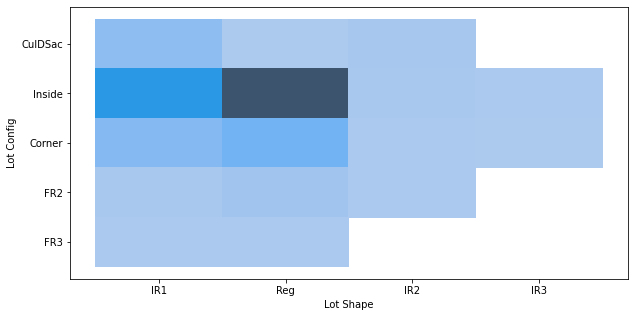

In [35]:
# histplot for lot shape vs lot config
plot_hist('Lot Shape', 'Lot Config', train)

It appears that majority of the houses are lot shape = regular and lot config = inside. We could group them into a binary variable Lot_is_Reg_Inside and drop the two original columns.

In [36]:
# binarize lot_is_reg_inside and drop original columns
def x_fn(row):
    row[
        'Lot_is_Reg_Inside'
    ] = 1 if row[
        'Lot Shape'
    ] == 'Reg' and row[
        'Lot Config'
    ] == 'Inside' else 0
    return row
        
train = train.apply(x_fn, axis=1).drop(columns=['Lot Shape', 'Lot Config'])

test = test.apply(x_fn, axis=1).drop(columns=['Lot Shape', 'Lot Config'])

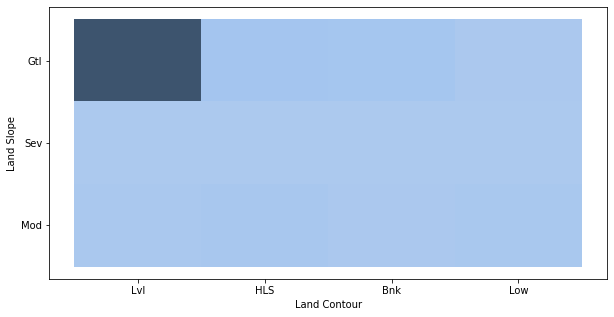

In [37]:
# histplot for land contour vs land slope
plot_hist('Land Contour', 'Land Slope', train)

Similarly to the lot comparison, majority of houses are on gentle slopage and level ground. We will binarize this to a variable called Land_is_Gtl_Lvl and drop the original columns.

In [38]:
# binarize land_is_gtl_lvl and drop original columns
def x_fn(row):
    row[
        'Land_is_Gtl_Lvl'
    ] = 1 if row[
        'Land Slope'
    ] == 'Gtl' and row[
        'Land Contour'
    ] == 'Lvl' else 0
    return row
        
train = train.apply(x_fn, axis=1).drop(columns=['Land Slope', 'Land Contour'])

test = test.apply(x_fn, axis=1).drop(columns=['Land Slope', 'Land Contour'])

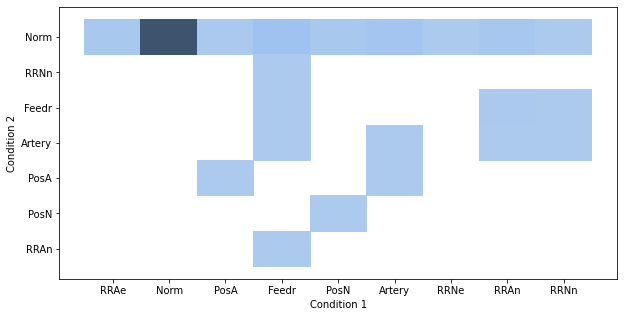

In [39]:
# Comparing condition 1 to condition 2
plot_hist('Condition 1', 'Condition 2', train)

Similarly to the previous comparison, majority of houses are not near any railroads or parks. We will binarize this to a variable called Location_is_Normal and drop the original columns.

In [40]:
# binarize location_is_normal and drop original columns
def x_fn(row):
    row[
        'Location_is_Normal'
    ] = 1 if row[
        'Condition 1'
    ] == 'Norm' and row[
        'Condition 2'
    ] == 'Norm' else 0
    return row
        
train = train.apply(x_fn, axis=1).drop(columns=['Condition 1', 'Condition 2'])

test = test.apply(x_fn, axis=1).drop(columns=['Condition 1', 'Condition 2'])

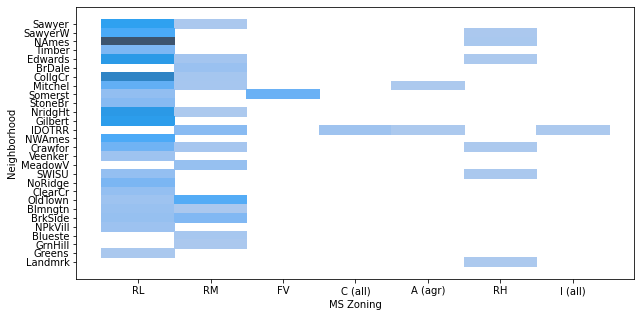

In [41]:
# compare between MS Zoning and Neighborhood
plot_hist('MS Zoning', 'Neighborhood', train)

It is rather difficult to group them by a binary configuration. However, it is clear that there are very few houses in MS Zones FV, C, A, RH and I. In that case, we could drop those, group the remaining values in MS Zoning and Neighborhood into a variable  called Neighborhood_Zone then finally dummifying that variable.

In [42]:
# Dropping houses that are not RL or RM MS Zoning
train = train[train['MS Zoning'].isin(['RL', 'RM'])]

In [43]:
# group and dummify the 2 columns
train = group_and_drop(
    'Neighborhood_Zone',
    'Neighborhood',
    'MS Zoning',
    train
)

train = pd.get_dummies(
    train,
    columns=[
        'Neighborhood_Zone'
    ], drop_first=True
) # dummify grouped column

test = group_and_drop(
    'Neighborhood_Zone',
    'Neighborhood',
    'MS Zoning',
    test
)

test = pd.get_dummies(
    test,
    columns=[
        'Neighborhood_Zone'
    ], drop_first=True
)

train, test = train.align(
    test,
    join='left',
    axis=1
)

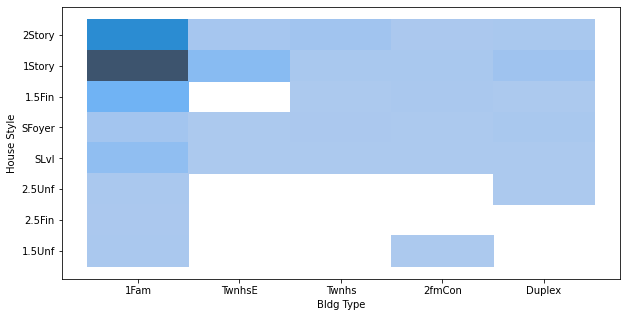

In [44]:
# Comparing Bldg Type and House Style
plot_hist('Bldg Type', 'House Style', train)

In [45]:
(train['Bldg Type'] != '1Fam').value_counts()

False    1467
True      279
Name: Bldg Type, dtype: int64

There is too significant a number of houses that are not 1Fam Building Type that it is unwise to drop all of them. However, since 2fmCon houses were originally built as a 1Fam house, they can be grouped into a new value called sing_fam. Similarly, TwnhsE and Twnhs can be grouped into a new value called twnhse. Then, the 3 building types can be grouped with house style into a variable called Hse_Style_Type and dummified.

In [46]:
# regrouping values in Bldg Type
def x_fn(row):
    if row['Bldg Type'] in ['1Fam', '2fmCon']:
        row['Bldg Type'] = 'sing_fam'
    elif row['Bldg Type'] in ['TwnhsE', 'Twnhs']:
        row['Bldg Type'] = 'twnhse'
    return row

train = train.apply(x_fn, axis=1)

test = test.apply(x_fn, axis=1)

In [47]:
# group and dummify the 2 columns
train = group_and_drop(
    'Hse_Style_Type',
    'House Style',
    'Bldg Type',
    train
)

train = pd.get_dummies(
    train,
    columns=[
        'Hse_Style_Type'
    ], drop_first=True
) # dummify grouped column

test = group_and_drop(
    'Hse_Style_Type',
    'House Style',
    'Bldg Type',
    test
)

test = pd.get_dummies(
    test,
    columns=[
        'Hse_Style_Type'
    ], drop_first=True
) # dummify grouped column

train, test = train.align(
    test,
    join='left',
    axis=1
)

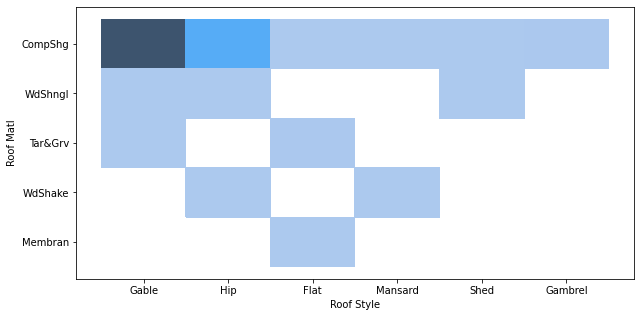

In [48]:
# compare roof style and roof matl
plot_hist('Roof Style', 'Roof Matl', train)

Majority are roof material composite shingle and roof style gable, so we group them into a binary variable Roof_is_CompShg_Gable.

In [49]:
# binarize roof_is_compshg_gable and drop original columns
def x_fn(row):
    row[
        'Roof_is_CompShg_Gable'
    ] = 1 if row[
        'Roof Matl'
    ] == 'CompShg' and row[
        'Roof Style'
    ] == 'Gable' else 0
    return row
        
train = train.apply(
    x_fn,
    axis=1
).drop(
    columns=[
        'Roof Matl',
        'Roof Style'
    ]
)

test = test.apply(
    x_fn,
    axis=1
).drop(
    columns=[
        'Roof Matl',
        'Roof Style'
    ]
)

For exterior 1st and exterior 2nd, there should be high collinearity between them and Exter Qual and Cond. Going by this assumption, we should drop these columns.

In [50]:
train = train.drop(
    columns=[
        'Exterior 1st',
        'Exterior 2nd'
    ]
)

test = test.drop(
    columns=[
        'Exterior 1st',
        'Exterior 2nd'
    ]
)

Comparing exterior quality and exterior condition, since they are ordinal variables of the same scale, we will convert the variables to a scale score of 1 - 5 and then take the mean of the two.

In [51]:
# encode columns
train = mean_drop(
    'Exter Qual',
    'Exter Cond',
    'Exter_Qual_Cond',
    train
)

test = mean_drop(
    'Exter Qual',
    'Exter Cond',
    'Exter_Qual_Cond',
    test
)

Comparing Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1 and BsmtFin Type 2, the most insignificant features are Bsmt Exposure, BsmtFin Type 1 and 2. We will convert Bsmt Qual and Bsmt Cond using the same scale as before and then take the mean of the two. We will then drop all the original columns.

In [52]:
# encode columns
train = mean_drop(
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt_Qual_Cond',
    train
)

test = mean_drop(
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt_Qual_Cond',
    test
)

# drop BsmtFin Types 1, 2 and Bsmt Exposure
train = train.drop(columns=[
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
])

test = test.drop(columns=[
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
])

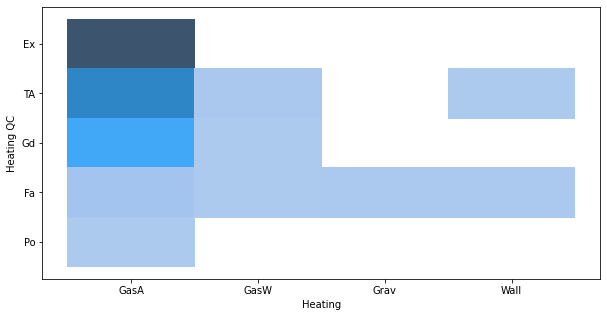

In [53]:
# comparing heating and heating qc
plot_hist('Heating', 'Heating QC', train)

In [54]:
# get percentage of houses heating types
train['Heating'].value_counts(normalize=True)

GasA    0.986254
GasW    0.008591
Wall    0.002864
Grav    0.002291
Name: Heating, dtype: float64

There are very few houses with heating that is not GasA type. We can drop those houses, then drop the column and then encode heating QC.

In [55]:
# drop houses that are not gasA type
train = train[train['Heating'] == 'GasA']
train = train.drop(columns=['Heating'])

test = test.drop(columns=['Heating'])

# encode heating qc
train = encode_scale('Heating QC', train)

test = encode_scale('Heating QC', test)

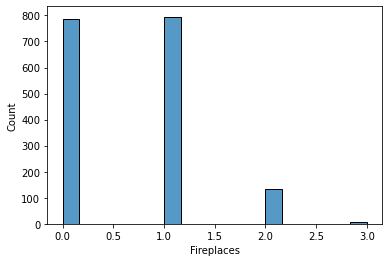

In [56]:
# count houses with fireplace
sns.histplot(data=train, x='Fireplaces');

The fireplace column is already in numerical discrete form, and so can be left alone. We can simply encode the fireplace quality column.

In [57]:
# count fireplace qu
train = encode_scale('Fireplace Qu', train)

test = encode_scale('Fireplace Qu', test)

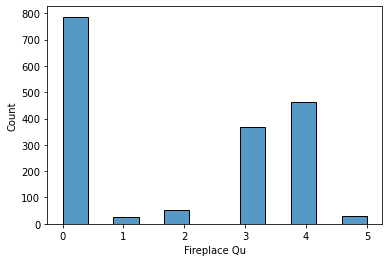

In [58]:
sns.histplot(data=train, x='Fireplace Qu');

In [59]:
# compare garage type and garage finish
train['Garage Finish'].value_counts()

Unf    690
RFn    497
Fin    454
0       81
Name: Garage Finish, dtype: int64

In [60]:
train['Garage Type'].value_counts()

Attchd     1076
Detchd      393
BuiltIn     125
0            81
Basment      25
2Types       14
CarPort       8
Name: Garage Type, dtype: int64

It is unlikely that having a garage interior finish will affect sale price significantly. In fact, experts claim that a finished interior could even hurt a house's price (source: https://www.homelight.com/blog/does-a-finished-garage-add-value/#:~:text=A%20finished%20garage%20won't,means%20everything%2C%E2%80%9D%20says%20McKee). Also the type of garage is also found to be insignificant. What is important, however is the existence of a garage. Thus, we drop these two columns.

In [61]:
train = train.drop(
    columns=[
        'Garage Finish',
        'Garage Type'
    ]
)

test = test.drop(
    columns=[
        'Garage Finish',
        'Garage Type'
    ]
)

For Garage Qual and Cond, we perform the above steps used for Bsmt and Exter.

In [62]:
# encode columns
train = mean_drop(
    'Garage Qual',
    'Garage Cond',
    'Garage_Qual_Cond',
    train
)

test = mean_drop(
    'Garage Qual',
    'Garage Cond',
    'Garage_Qual_Cond',
    test
)

### Final Touches

In [63]:
# get a list of dtype objects
list(train.select_dtypes(['object']).columns)

['Street',
 'Utilities',
 'Foundation',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Paved Drive',
 'Fence',
 'Sale Type']

There are several columns still containing str values. Let's take a look at how to tackle these columns.

   - Street: Only contains values 'Gravel' or 'Paved'. Convert to binary var 'is_paved' where 'Paved': 1, 'Gravel': 0.
   
   
   - Utilities: There is only 1 house which is not AllPub (see value_counts below). We will drop this column.
   
   
   - Foundation: Foundation types have little effect on house price according to source (https://www.homes.com/blog/2013/01/foundations-affect-on-home-value/). What actually matters is whether the foundation has issues. Column to be dropped.
   
   
   - Central Air: Nominal list with 2 unique values: Yes and No. Simple binarization to Yes: 1, No: 0.
   
   
   - Electrical: Data dictionary states it as an ordinal list, which implies that SBrkr>FuseA>FuseF>FuseP>Mix. We can scale it from 5 to 1 respectively.
   
   
   - Kitchen Qual: Ordinal list where we can use encode_scale function as it uses the same rating system.
   
   
   - Functional: Remap Typ: 8, Min1: 7, Min2: 6, Mod: 5, Maj1: 4, Maj2: 3, Sev: 2, Sal: 1. 
   
   
   - Paved Drive: Binarize to whether it has a paved drive, with yes being 1.
   
   
   - Fence: The ratings are rather arbitrary, with good privacy not having much of a correlation with whether it is made of good wood. Thus, we will binarize this column to whether a house has a fence or not, with 1 being yes.
   
   
   - Sale Type: Unnecessary column, to be dropped.

In [64]:
# convert street to binary
train = binarize_(
    'Street',
    'is_paved',
    'Pave',
    'Grvl',
    train
)

test = binarize_(
    'Street',
    'is_paved',
    'Pave',
    'Grvl',
    test
)

In [65]:
train['Utilities'].value_counts()

AllPub    1721
NoSeWa       1
Name: Utilities, dtype: int64

In [66]:
# drop utilities and foundation
train = train.drop(columns=['Utilities', 'Foundation'])

test = test.drop(columns=['Utilities', 'Foundation'])

In [67]:
# convert central air to binary
train = binarize_(
    'Central Air',
    'has_ctrl_aircon',
    'Y',
    'N',
    train
)

test = binarize_(
    'Central Air',
    'has_ctrl_aircon',
    'Y',
    'N',
    test
)

In [68]:
# scale electrical
train['Electrical'] = train['Electrical'].map({
    'SBrkr': 5,
    'FuseA': 4,
    'FuseF': 3,
    'FuseP': 2,
    'Mix': 1
})

test['Electrical'] = test['Electrical'].map({
    'SBrkr': 5,
    'FuseA': 4,
    'FuseF': 3,
    'FuseP': 2,
    'Mix': 1
})

In [69]:
# scale kitchen qual
train = encode_scale('Kitchen Qual', train)

test = encode_scale('Kitchen Qual', test)

In [70]:
# scale functional
train['Functional'] = train['Functional'].map({
    'Typ': 8,
    'Min1': 7,
    'Min2': 6,
    'Mod': 5,
    'Maj1': 4,
    'Maj2': 3,
    'Sev': 2,
    'Sal': 1
})

test['Functional'] = test['Functional'].map({
    'Typ': 8,
    'Min1': 7,
    'Min2': 6,
    'Mod': 5,
    'Maj1': 4,
    'Maj2': 3,
    'Sev': 2,
    'Sal': 1
})

In [71]:
# binarize paved drive
train['has_paved_drive'] = train['Paved Drive'].map({
    'Y': 1,
    'N': 0,
    'P': 0,
})

test['has_paved_drive'] = test['Paved Drive'].map({
    'Y': 1,
    'N': 0,
    'P': 0,
})

train = train.drop(columns='Paved Drive')

test = test.drop(columns='Paved Drive')

In [72]:
# binarize fence
train['has_fence'] = train['Fence'].map({
    'MnPrv': 1,
    'GdPrv': 1,
    'GdWo': 1,
    'MnWw': 1,
    0: 0
})

test['has_fence'] = test['Fence'].map({
    'MnPrv': 1,
    'GdPrv': 1,
    'GdWo': 1,
    'MnWw': 1,
    0: 0
})

train = train.drop(columns='Fence')

test = test.drop(columns='Fence')

In [73]:
# drop sale type
train = train.drop(columns='Sale Type')

test = test.drop(columns='Sale Type')

In [74]:
# final checks. first, confirm no more null values
train.isnull().sum().sort_values(ascending=False).head(1)

Lot Area    0
dtype: int64

In [75]:
# final checks. secondly, confirm no more dtype objects
list(train.select_dtypes(['object']).columns)

[]

In [76]:
list(test.select_dtypes(['object']).columns)

[]

In [77]:
# changing column names to lowercase to make it friendlier to read
train = lower_names(train)

test = lower_names(test)

## Exploratory Data Analysis


In [78]:
# summary statistics
train.describe().T.sort_values('std', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
saleprice,1722.0,185345.693380,81187.519278,12789.0,131125.00,165000.0,217000.00,611657.0
lot_area,1722.0,10153.458188,5893.455767,1300.0,7660.75,9535.0,11744.25,115149.0
gr_liv_area,1722.0,1499.738676,492.493667,334.0,1121.25,1456.0,1732.75,3820.0
total_bsmt_sf,1722.0,1080.141696,428.571303,0.0,816.00,1030.5,1348.00,3200.0
garage_area,1722.0,478.963415,211.947250,0.0,336.00,480.0,576.00,1356.0
wood_deck_sf,1722.0,97.560395,129.523155,0.0,0.00,0.0,168.00,1424.0
open_porch_sf,1722.0,43.924506,60.526809,0.0,0.00,25.0,66.00,502.0
house_age,1722.0,46.979094,27.523940,12.0,20.00,45.0,65.00,146.0
fireplace_qu,1722.0,1.869338,1.806696,0.0,0.00,2.0,4.00,5.0
overall_qual,1722.0,6.160279,1.390965,1.0,5.00,6.0,7.00,10.0


There are several features worth exploring. Specifically, there are some continuous and discrete features with a very high standard deviation for their mean. These include lot_area, total_bsmt_sf, gr_liv_area, garage_area, wood_deck_sf, open_porch_sf, saleprice, house_age.

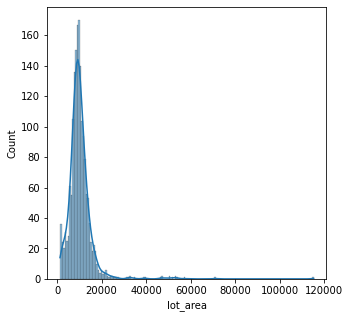

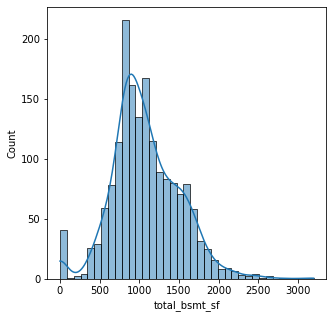

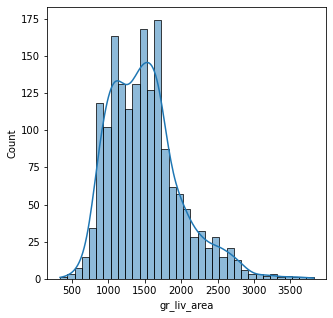

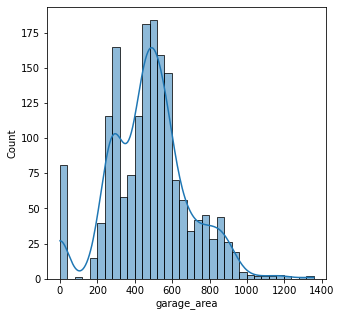

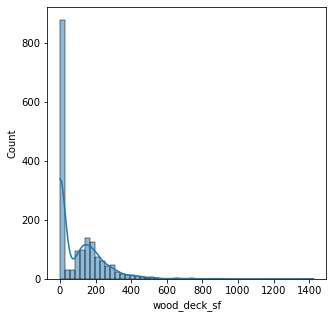

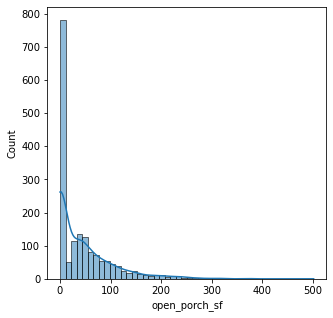

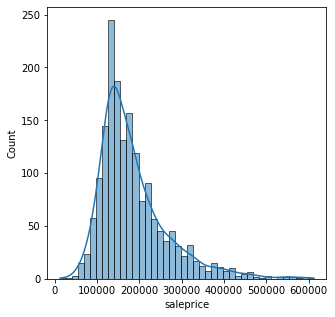

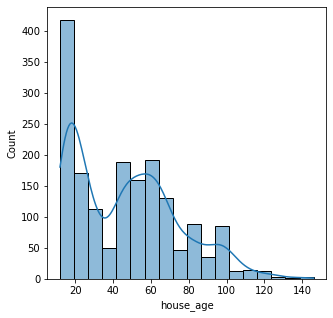

In [79]:
# plot histograms for features with high std
list_ = [
    'lot_area',
    'total_bsmt_sf',
    'gr_liv_area',
    'garage_area',
    'wood_deck_sf',
    'open_porch_sf',
    'saleprice',
    'house_age'
        ]

plot_list_hists(list_, train)

We see that many variables are skewed to the left, signalling outliers on the far right. This is inclusive of saleprice. However, the greatest offenders are lot_area, which has massive outliers, and wood_porch_sf and open_porch_sf, which have far too many 0 values.

We could binarize wood_deck_sf and open_porch_sf as well as remove row with lot_area > 20000, especially since there are only 46 such houses.

In [80]:
train.loc[train['lot_area'] > 20000, 'lot_area'].value_counts().sum()

46

In [81]:
# remove rows with lot_area > 20000
train = train.loc[train['lot_area'] < 20001]

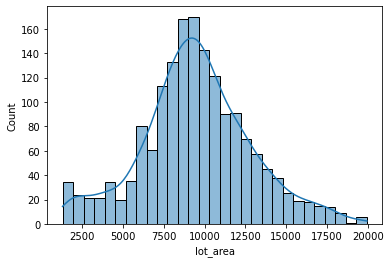

In [82]:
# visualize lot_area again
sns.histplot(train['lot_area'], kde=True);

In [83]:
# binarize wood_deck_sf and open_porch_sf
train['has_wood_deck'] = (train['wood_deck_sf'] == 0) * 1
train['has_open_porch'] = (train['open_porch_sf'] == 0) * 1
train = train.drop(columns=['wood_deck_sf', 'open_porch_sf'])

test['has_wood_deck'] = (test['wood_deck_sf'] == 0) * 1
test['has_open_porch'] = (test['open_porch_sf'] == 0) * 1
test = test.drop(columns=['wood_deck_sf', 'open_porch_sf'])

Now we try to remove a few outliers from saleprice to try to get it closer to a normal distribution.

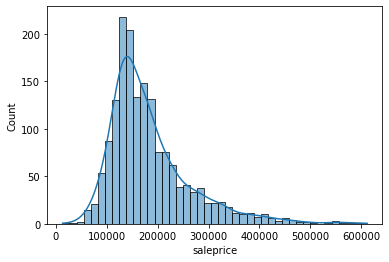

In [84]:
# visualize target variable SalePrice
sns.histplot(train['saleprice'], kde=True);

In [85]:
# get count of houses with saleprice greater than 400000
train.loc[train['saleprice'] > 400000, 'saleprice'].value_counts().sum()

42

There is a heavy left skew due to outliers on the right. In order to try to reduce the skew, we can drop rows with saleprice > 400000. Since there are only 42 such houses out of 1722, we can safely drop them.

In [86]:
# remove rows with saleprice > 400000
train = train.loc[train['saleprice'] < 400001]

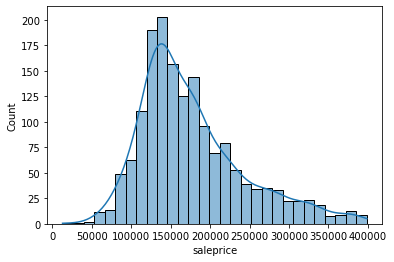

In [87]:
# visualize saleprice again
sns.histplot(train['saleprice'], kde=True);

Now, we pull out the features that have a greater than 0.5 correlation to SalePrice as a sort of baseline comparison.

In [88]:
# checking number of rows left in train data
train.shape

(1634, 80)

In [89]:
# series of features correlating with SalePrice,
# in which absolute correlation value is greater than 0.5
corr_values = train.corr()['saleprice'].sort_values(ascending=False)
corr_values[(corr_values > 0.5) | (corr_values < -0.5)]

saleprice          1.000000
overall_qual       0.810452
gr_liv_area        0.718534
kitchen_qual       0.690411
garage_area        0.659729
total_bsmt_sf      0.627745
exter_qual_cond    0.594418
full_bath          0.566175
fireplace_qu       0.528705
bsmt_qual_cond     0.511997
house_age         -0.607994
Name: saleprice, dtype: float64

The features with the highest correlation are overall quality, general living area, kitchen quality, garage area, total basement square footage, external quality and condition, full bath, fireplace quality, basement quality and condition, as well as house age.

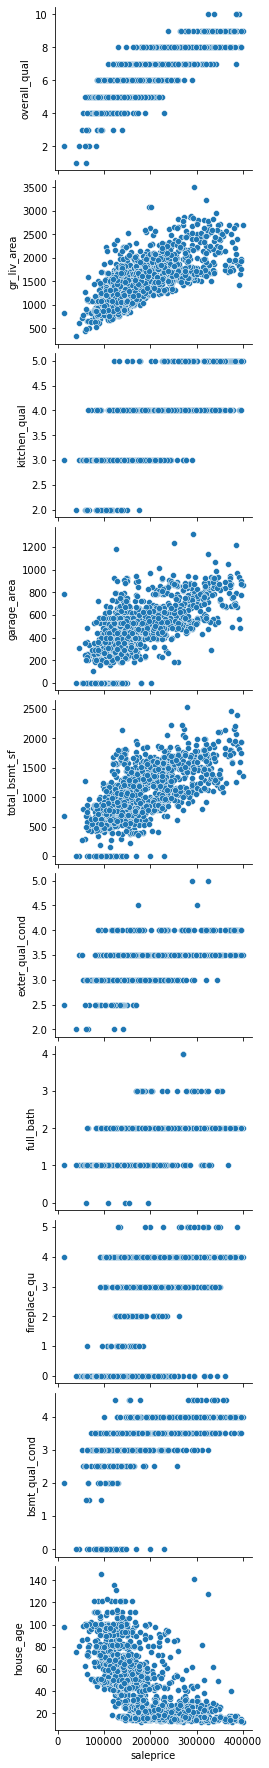

In [90]:
list_good_features = [
    'overall_qual',
    'gr_liv_area',
    'kitchen_qual',
    'garage_area',
    'total_bsmt_sf',
    'exter_qual_cond',
    'full_bath',
    'fireplace_qu',
    'bsmt_qual_cond',  
    'house_age',
]

sns.pairplot(train,
             y_vars=list_good_features,
             x_vars=['saleprice'],
            aspect=1.5);

The scatterplots don't seem too interesting, with the exception of outliers in house_age. Generally, sale price decreases as house age increases, but there are 2 houses with a high sale price and are above 100 years old. 

In [91]:
# isolating the two outliers
train.loc[(train['house_age'] > 100) & (train['saleprice'] > 250000), :]

,lot_area,overall_qual,total_bsmt_sf,heating_qc,electrical,gr_liv_area,full_bath,kitchen_qual,functional,fireplaces,...,roof_is_compshg_gable,exter_qual_cond,bsmt_qual_cond,garage_qual_cond,is_paved,has_ctrl_aircon,has_paved_drive,has_fence,has_wood_deck,has_open_porch
1141,13500,10,1237.0,4,5,2775,3,4,8,1,...,1,5.0,3.0,3.5,1,1,1,0,0,0
1939,18386,7,1470.0,5,5,3493,3,4,8,1,...,1,3.0,3.0,3.0,1,1,1,0,0,1


In [92]:
# dropping the two outliers
train = train.drop([1141, 1939])

Now, let's take a look at boxplots.

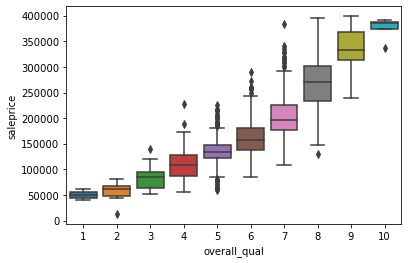

In [93]:
# boxplots for categorical features with absolute correlation > 0.5
sns.boxplot(x='overall_qual', y='saleprice', data=train);

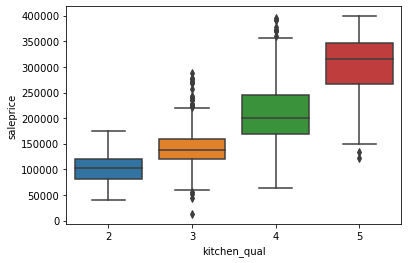

In [94]:
sns.boxplot(x='kitchen_qual', y='saleprice', data=train);

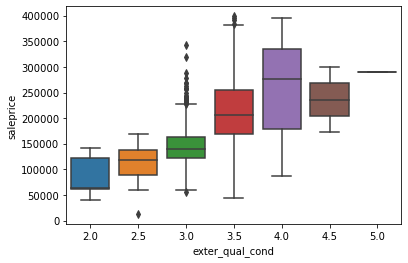

In [95]:
sns.boxplot(x='exter_qual_cond', y='saleprice', data=train);

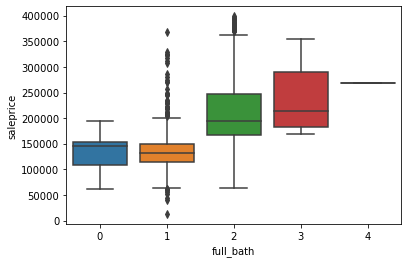

In [96]:
sns.boxplot(x='full_bath', y='saleprice', data=train);

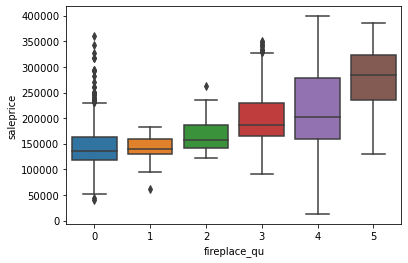

In [97]:
sns.boxplot(x='fireplace_qu', y='saleprice', data=train);

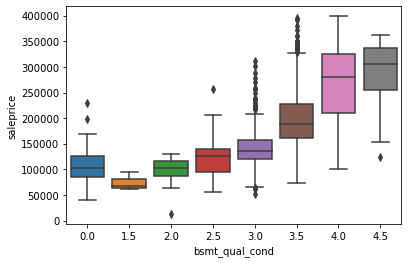

In [98]:
sns.boxplot(x='bsmt_qual_cond', y='saleprice', data=train);

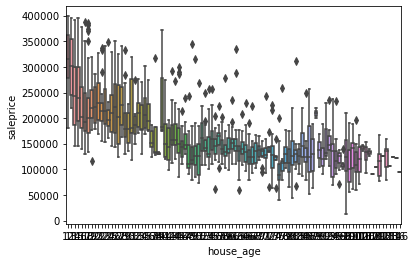

In [99]:
sns.boxplot(x='house_age', y='saleprice', data=train);

The boxplots do not show any particular outliers of note. However, it does show that having a fireplace might not be that big of a factor on sale price.

### Clean Test Data and Export

In [100]:
# check train and test data shapes
print(train.shape)
print(test.shape)

(1632, 80)
(879, 80)


In [101]:
train.head(1)

,lot_area,overall_qual,total_bsmt_sf,heating_qc,electrical,gr_liv_area,full_bath,kitchen_qual,functional,fireplaces,...,roof_is_compshg_gable,exter_qual_cond,bsmt_qual_cond,garage_qual_cond,is_paved,has_ctrl_aircon,has_paved_drive,has_fence,has_wood_deck,has_open_porch
0,13517,6,725.0,5,5,1479,2,4,8,0,...,1,3.5,3.0,3.0,1,1,1,0,1,0


In [102]:
test.head(1)

,lot_area,overall_qual,total_bsmt_sf,heating_qc,electrical,gr_liv_area,full_bath,kitchen_qual,functional,fireplaces,...,roof_is_compshg_gable,exter_qual_cond,bsmt_qual_cond,garage_qual_cond,is_paved,has_ctrl_aircon,has_paved_drive,has_fence,has_wood_deck,has_open_porch
0,9142,6,1020,4,2.0,1928,2,2,8,0,...,1,2.5,2.5,1.0,1,0,1,0,1,0


In [103]:
# clean differences in train and test set
test = test.drop(columns='saleprice')
test = test.fillna(0)

In [104]:
# final check train and test data shapes
print(train.shape)
print(test.shape)

(1632, 80)
(879, 79)


In [105]:
# export to csv
train.to_csv('../datasets/train_clean.csv')
test.to_csv('../datasets/test_clean.csv')

## Data Modelling

### Train-Test Split and Scaling

In [106]:
# determination of x and y features
X = train.drop(columns='saleprice')
y = train['saleprice']

In [107]:
# train-test-split of train set to train and holdout sets

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [108]:
# instantiate StandardScaler and transform
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_holdout = ss.transform(X_holdout)

### Linear Regression

In [109]:
# instantiate LinearRegression
lr = LinearRegression()

In [110]:
# fit model
lr_basic = lr.fit(Z_train, y_train)

In [111]:
# baseline r2
lr_basic.score(Z_train, y_train)

0.9047661892538099

In [112]:
# holdout r2
lr_basic.score(Z_holdout, y_holdout)

0.8902364343761786

In [113]:
# cross validation score
np.sqrt(
    np.abs(
        cross_val_score(
            lr,
            X_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9417485937144146

In [114]:
# predict y
y_predict = lr_basic.predict(Z_holdout)

In [115]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_holdout, y_predict))

20793.593077898553

### Ridge Regression

In [116]:
# instantiate model
ridge_a10 = Ridge(alpha=10)

In [117]:
# fit model
ridge_a10.fit(Z_train, y_train)

Ridge(alpha=10)

In [118]:
# baseline r2
ridge_a10.score(Z_train, y_train)

0.9047099602153512

In [119]:
# holdout r2
ridge_a10.score(Z_holdout, y_holdout)

0.8902821581520023

In [120]:
# cross validation score
np.sqrt(
    np.abs(
        cross_val_score(
            ridge_a10,
            Z_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9420784810213731

In [121]:
ridge_a10_pred = ridge_a10.predict(Z_holdout)

In [122]:
# RMSE for ridge alpha 10
np.sqrt(metrics.mean_squared_error(y_holdout, ridge_a10_pred))

20789.261674224483

In [123]:
# list of ridge alphas to check
r_alphas = np.logspace(0, 50, 100)

# cross validate over list
regr_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# fit with best alpha
ridge_cv = regr_cv.fit(Z_train, y_train)

In [124]:
# optimal value of alpha
ridge_cv.alpha_

32.74549162877728

In [125]:
# repeat for optimal value of alpha
ridge_aoptimal = Ridge(alpha=32.74549162877728)
ridge_aoptimal.fit(Z_train, y_train)
np.sqrt(
    np.abs(
        cross_val_score(
            ridge_aoptimal,
            Z_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9421942665994856

In [126]:
ridge_aoptimal_pred = ridge_aoptimal.predict(Z_holdout)

In [127]:
np.sqrt(metrics.mean_squared_error(y_holdout, ridge_aoptimal_pred))

20796.163134621125

### LASSO Regression

In [128]:
# instantiate model
lasso_a200 = LassoCV(n_alphas=200)

In [129]:
# fit model
lasso_a200.fit(Z_train, y_train)

LassoCV(n_alphas=200)

In [130]:
# baseline r2
lasso_a200.score(Z_train, y_train)

0.9042350137784163

In [131]:
# holdout r2
lasso_a200.score(Z_holdout, y_holdout)

0.8911519333814975

In [132]:
# cross validation score
np.sqrt(
    np.abs(
        cross_val_score(
            lasso_a200,
            Z_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9419017113989967

In [133]:
lasso_a200_pred = lasso_a200.predict(Z_holdout)

# RMSE for lasso alpha 200
np.sqrt(metrics.mean_squared_error(y_holdout, lasso_a200_pred))

20706.695507284032

In [134]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

# Fit model using best ridge alpha!
lasso_cv.fit(Z_train, y_train);

In [135]:
# Here is the optimal value of alpha
lasso_cv.alpha_

1.0

In [136]:
# repeat for optimal value of alpha
lasso_aoptimal = LassoCV(n_alphas=1)
lasso_aoptimal.fit(Z_train, y_train)
np.sqrt(
    np.abs(
        cross_val_score(
            lasso_aoptimal,
            Z_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9421245758361945

In [137]:
lasso_aoptimal_pred = lasso_aoptimal.predict(Z_holdout)

# RMSE for lasso alpha optimal
np.sqrt(metrics.mean_squared_error(y_holdout, lasso_aoptimal_pred))

20746.671233003854

### ElasticNet Regularization

In [138]:
# Set up a list of alphas to check
enet_alphas = np.linspace(0.5, 1.0, 100)

# Instantiate model
enet_model1 = ElasticNetCV(alphas=enet_alphas, l1_ratio=0.5, cv=5)

# Fit model using optimal alpha
enet_model1 = enet_model1.fit(Z_train, y_train)

In [139]:
# optimal alpha
enet_model1.alpha_

0.5

In [140]:
# cross val score
np.sqrt(
    np.abs(
        cross_val_score(
            enet_model1,
            Z_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9390232911134095

In [141]:
enet_pred1 = enet_model1.predict(Z_holdout)

In [142]:
# RMSE for elasticnet model
np.sqrt(metrics.mean_squared_error(y_holdout, enet_pred1))

21216.874918794816

#### Repeat for l1 ratio = 0.9

In [143]:
# Set up a list of alphas to check
enet_alphas = np.linspace(0.5, 1.0, 100)

# Instantiate model
enet_model2 = ElasticNetCV(alphas=enet_alphas, l1_ratio=0.9, cv=5)

# Fit model using optimal alpha
enet_model2 = enet_model2.fit(Z_train, y_train)

In [144]:
# optimal alpha
enet_model2.alpha_

0.5

In [145]:
# cross val score
np.sqrt(
    np.abs(
        cross_val_score(
            enet_model2,
            Z_train,
            y_train,
            cv=5,
        ).mean(
        )
    )
)

0.9420365448965485

In [146]:
enet_pred2 = enet_model2.predict(Z_holdout)

In [147]:
# RMSE for elasticnet model
np.sqrt(metrics.mean_squared_error(y_holdout, enet_pred2))

20823.03884079805

### Model Selection and Interpretation

The results for the models used are as follows.

|Model|Hyperparamters|Features|CVS|Holdout RMSE|Kaggle RMSE|
|-----|--------------|--------|-------|------------|-----------|
|Linear Regression|None|79|0.941749|20793.59|NA|
|Ridge Regression|alpha=10|79|0.942078|20789.26|NA|
|Ridge Regression|alpha=32.75|79|0.942194|20796.16|NA|
|LASSO Regression|alpha=200|79|0.941901|20706.70|31763.91|
|LASSO Regression|alpha=1|79|0.942125|20746.67|NA|
|ElasticNet Regression|alpha=0.5, l1 ratio=0.5|79|0.939023|21216.87|NA|
|ElasticNet Regression|alpha=0.5, l1 ratio=0.9|79|0.942036|20823.04|NA|

The model with the best performance currently is LASSO regression with alpha = 200.

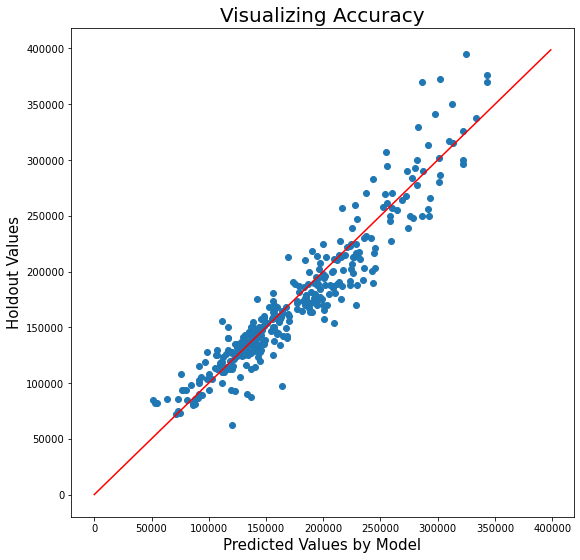

In [148]:
# plot scatter visualizing accuracy
plt.figure(figsize=(9,9))
plt.scatter(lasso_a200_pred, y_holdout)
plt.plot([0, np.max(y)], [0, np.max(y)], color='red')
plt.xlabel('Predicted Values by Model', fontsize=15)
plt.ylabel('Holdout Values', fontsize=15)
plt.title('Visualizing Accuracy', fontsize=20);

Accuracy is decent, with a few values off at the lowest and highest prices.

### Train Chosen Model on Full Train Data

In [149]:
# instantiate StandardScaler and transform
ss = StandardScaler()
ss.fit(X)
Z_full = ss.transform(X)
Z_test = ss.transform(test)

# train model on full train data
final_lasso = LassoCV(n_alphas=200)
final_lasso.fit(Z_full, y)

# predict values
final_lasso_pred = final_lasso.predict(Z_test)

In [150]:
# convert predictions to dataframe
submission1 = pd.DataFrame()
submission1['Id'] = test_id
submission1['SalePrice'] = final_lasso_pred

In [151]:
# check
submission1.shape

(879, 2)

In [152]:
submission1.head()

,Id,SalePrice
0,2658,142761.268560
1,2718,181070.152788
2,2414,210565.481010
3,1989,112013.668117
4,625,177635.094890


### Export to Kaggle

In [153]:
submission1.to_csv('../datasets/submission1.csv', index=False)

This submission got a RMSE of 31763.90846 on Kaggle, which is within expectations.

## Conclusions and Recommendations

In [154]:
coeff_df = pd.DataFrame(
    set(
        zip(
            X.columns,
            lasso_a200.coef_
        )
    )
).rename(
    columns={
        0: 'Feature',
        1: 'Coefficient'
    }
).sort_values(
    'Coefficient',
    ascending=False
)

coeff_df.sort_values('Coefficient').head(10)

,Feature,Coefficient
70,house_age,-10262.931438
74,hse_style_type_2story_twnhse,-3382.168455
37,land_is_gtl_lvl,-2704.322495
39,hse_style_type_1story_twnhse,-2378.809296
10,garage_qual_cond,-2315.887071
61,neighborhood_zone_sawyerw_rl,-2015.856926
14,hse_style_type_2.5fin_sing_fam,-1802.786072
7,hse_style_type_1story_duplex,-1714.150491
38,neighborhood_zone_gilbert_rl,-1544.060242
19,neighborhood_zone_nwames_rl,-1537.683178


Interestingly, having land on gentle slope and level ground actually decreases the price. This effect is presumably due to this coefficient being a comparison with the dropped dummy variable while getting dummies, but it is hard to tell which variable was dropped.

In [155]:
coeff_df

,Feature,Coefficient
33,gr_liv_area,19567.732739
17,overall_qual,13265.367032
20,garage_area,7667.611571
62,lot_area,7559.167036
60,total_bsmt_sf,7502.058711
...,...,...
10,garage_qual_cond,-2315.887071
39,hse_style_type_1story_twnhse,-2378.809296
37,land_is_gtl_lvl,-2704.322495
74,hse_style_type_2story_twnhse,-3382.168455


The top features that affect price the most are square footage focused, which is to be expected. These are General Living Area, Garage Area, Lot Area and Basement Area.

Also the overall quality of the house is extremely important, as well as the age of the house. These findings are within logical reason.

The real estate firm should be encouraged to focus their price setting on these area figures, rather than categorical features like whether the house has an open porch.